<a href="https://colab.research.google.com/github/kasri-mids/MovieGenreClassification/blob/master/src/Analysis/Error_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Error Analysis Notebook

In this notebook, we take a closer look at the results from the models we built and analyze the errors.

In [0]:
#%tensorflow_version 2.1
!pip install tensorflow==2.1.0

import tensorflow as tf
print(tf.__version__)
# Imports

import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
from datetime import datetime
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import keras.backend.tensorflow_backend as tfb

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 3.9MB 36.3MB/s 
     |████████████████████████████████| 450kB 46.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=4317bf18a2b88d644a24fcdbebf89bdb654a3bc970ecc1b659090618e20201fe
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ERROR_TEST = 0
max_length = 128

if (ERROR_TEST):
    NUM_LABELS = 1
    OVERSAMPLING = False
    
    data_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/baseline_test/'
    model_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/model/baseline_test/'
    plot_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/plots/baseline_test/'
    data_load_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/'
else:
    NUM_LABELS = 10

    data_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/baseline/'
    model_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/model/baseline/'
    plot_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/plots/baseline/'
    data_load_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/'

In [0]:
optimizer_select = 'ADAM'
BATCH_SIZE = 128*8
EPOCHS = 30
LR = 1e-05
LOSS = 'bce'#'macro_double_soft_f1'#'bce'
#ACC = ['accuracy',macro_f1,micro_f1]
TRAIN_BERT = True
results_prefix = 'baseline_'  + optimizer_select + '_EPOCHS_' + str(EPOCHS) + '_LR_' + str(LR) + '_LOSS_' + str(LOSS)

In [0]:
X_train = np.load(data_load_prefix + 'clean_train_bert_tokens_' + str(max_length) + '.data.npy')
X_dev = np.load(data_load_prefix + 'clean_dev_bert_tokens_'  + str(max_length) + '.data.npy')
X_val = np.load(data_load_prefix + 'clean_val_bert_tokens_'  + str(max_length) + '.data.npy')

y_train = np.load(data_load_prefix + 'clean_train_poster_labels_' + str(NUM_LABELS) + '.data.npy', allow_pickle=True)
y_dev = np.load(data_load_prefix + 'clean_dev_poster_labels_' + str(NUM_LABELS) + '.data.npy', allow_pickle=True)
y_val = np.load(data_load_prefix + 'clean_val_poster_labels_' + str(NUM_LABELS) + '.data.npy', allow_pickle=True)

posterVectors_train = np.load(data_load_prefix + 'clean_train_poster_vectors.data.npy', allow_pickle=True)
posterVectors_dev = np.load(data_load_prefix+ 'clean_dev_poster_vectors.data.npy', allow_pickle=True)
posterVectors_val = np.load(data_load_prefix+ 'clean_val_poster_vectors.data.npy', allow_pickle=True)

df_train = pd.read_csv(data_load_prefix + 'clean_df_train_labels_' + str(NUM_LABELS) + '.csv')
df_dev = pd.read_csv(data_load_prefix + 'clean_df_dev_labels_' + str(NUM_LABELS) + '.csv')
df_val = pd.read_csv(data_load_prefix + 'clean_df_val_labels_' + str(NUM_LABELS) + '.csv')

In [0]:
df_val.head()

,movieid_poster,indexes,movieid,movieplot,labels
0,tt0039689.jpg,72357,tt0039689.jpg,"In a small town in California, the mysterious ...","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0]"
1,tt7287656.jpg,71319,tt7287656.jpg,Su is a dreamer who believes that the love of ...,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
2,tt2754854.jpg,56809,tt2754854.jpg,"In the rural farm town of Appleton, Wisconsin,...","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]"
3,tt0035034.jpg,32236,tt0035034.jpg,Hank McHenry and Johnny Marshall work on a roa...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,tt4532826.jpg,28727,tt4532826.jpg,"Robin of Loxley, a lord living in Nottingham, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0]"


In [0]:
df_year = pd.read_csv('/content/drive/My Drive/w266-FinalProject/data/imdb_dataset.csv', usecols = ['movieid','year'])
df_year.movieid = df_year.movieid + '.jpg'
df_year.head()

,movieid,year
0,tt0007610.jpg,1917
1,tt0005078.jpg,1915
2,tt0007257.jpg,1916
3,tt0008011.jpg,1917
4,tt0003772.jpg,1914


In [0]:
df_val = df_val.merge(df_year,how='left', left_on='movieid', right_on='movieid')
df_val.head()

,movieid_poster,indexes,movieid,movieplot,labels,year
0,tt0039689.jpg,72357,tt0039689.jpg,"In a small town in California, the mysterious ...","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0]",1947
1,tt7287656.jpg,71319,tt7287656.jpg,Su is a dreamer who believes that the love of ...,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]",2019
2,tt2754854.jpg,56809,tt2754854.jpg,"In the rural farm town of Appleton, Wisconsin,...","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",2015
3,tt0035034.jpg,32236,tt0035034.jpg,Hank McHenry and Johnny Marshall work on a roa...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1941
4,tt4532826.jpg,28727,tt4532826.jpg,"Robin of Loxley, a lord living in Nottingham, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0]",2018


In [0]:
NUM_VAL_SAMPLES = int(np.floor(X_val.shape[1] / BATCH_SIZE) * BATCH_SIZE)
NUM_DEV_SAMPLES = int(np.floor(X_dev.shape[1] / BATCH_SIZE) * BATCH_SIZE)
print(NUM_VAL_SAMPLES)

15360


In [0]:
def filter_data(X, y, poster, n_size, reverse=False):
    if (reverse):
        X_out = [X[0][-n_size:].astype('int32'), X[1][-n_size:].astype('int32'),X[2][-n_size:].astype('int32'), poster[-n_size:].astype('float32')]
        y_out = y[-n_size:].astype('int32')
        poster_out = poster[-n_size:].astype('float32')
    else:
        X_out = [X[0][0:n_size].astype('int32'), X[1][0:n_size].astype('int32'),X[2][0:n_size].astype('int32'), poster[0:n_size].astype('float32')]
        y_out = y[0:n_size].astype('int32')
        poster_out = poster[0:n_size].astype('float32')

    return (X_out, y_out, poster_out)

rev = False

bert_inputs_dev_k, labels_dev_k, posterVectors_dev_k = filter_data(X_dev, 
                                                                   y_dev, 
                                                                   posterVectors_dev, 
                                                                   NUM_DEV_SAMPLES, 
                                                                   reverse=rev)

bert_inputs_val_k, labels_val_k, posterVectors_val_k = filter_data(X_val, 
                                                                   y_val, 
                                                                   posterVectors_val, 
                                                                   NUM_VAL_SAMPLES, 
                                                                   reverse=rev)

In [0]:
from tensorflow.keras.models import model_from_json

model_file = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/model/baseline/baseline_seqlen_128_ADAM_EPOCHS_30_LR_0.0001_LOSS_macro_double_soft_f1_10.json'
# load weights into new model
weights_file = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/model/baseline/baseline_seqlen_128_ADAM_EPOCHS_30_LR_0.0001_LOSS_macro_double_soft_f1_10_weights.h5'

# load json and create model
with open(model_file, "r") as json_file:
    loaded_model_json = json_file.read()

cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)
with strategy.scope():
    loaded_model = model_from_json(loaded_model_json, custom_objects = {
        'KerasLayer': hub.KerasLayer
    })

    loaded_model.load_weights(weights_file)
    print("Loaded model from disk")

    loaded_model.summary()
    results = loaded_model.predict(bert_inputs_val_k)
    results_dev = loaded_model.predict(bert_inputs_dev_k)


INFO:tensorflow:Initializing the TPU system: 10.100.84.130:8470


INFO:tensorflow:Initializing the TPU system: 10.100.84.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Loaded model from disk
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_

In [0]:
print(results)

[[bfloat16(0.0327148438) bfloat16(0.00897216797) bfloat16(1.1920929e-07)
  ... bfloat16(0) bfloat16(2.84910202e-05) bfloat16(0)]
 [bfloat16(1) bfloat16(0) bfloat16(1) ... bfloat16(0) bfloat16(0)
  bfloat16(0)]
 [bfloat16(0.94921875) bfloat16(3.12924385e-06) bfloat16(0.000782012939)
  ... bfloat16(0) bfloat16(1.49011612e-07) bfloat16(0)]
 ...
 [bfloat16(0.0147705078) bfloat16(0.00717163086) bfloat16(2.98023224e-08)
  ... bfloat16(0) bfloat16(0.000146865845) bfloat16(0)]
 [bfloat16(1) bfloat16(0) bfloat16(1) ... bfloat16(0) bfloat16(0)
  bfloat16(0)]
 [bfloat16(1) bfloat16(0) bfloat16(1) ... bfloat16(0) bfloat16(0)
  bfloat16(0)]]


In [0]:
label_names = ['Drama','Thriller','Comedy','Action','Crime',
                   'Horror','Romance','Adventure','Mystery','Sci-Fi']
df_val_trunc = df_val.iloc[:NUM_VAL_SAMPLES]
df_dev_trunc = df_dev.iloc[:NUM_DEV_SAMPLES]

In [0]:
y_pred = (results > 0.5).astype(int)
final_list = []
for i in range(y_pred.shape[0]):
    list_x = []
    for j in y_pred[i]:
        list_x.append(j)
    final_list.append(list_x)

y_pred_dev = (results_dev > 0.5).astype(int)
final_list_dev = []
for i in range(y_pred_dev.shape[0]):
    list_x = []
    for j in y_pred_dev[i]:
        list_x.append(j)
    final_list_dev.append(list_x)
df_val_trunc.loc[:,'Combined'] = [final_list]
df_dev_trunc.loc[:,'Combined'] = [final_list_dev]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
df_train.iloc[0]

movieid_poster                                        tt1786530.jpg
indexes                                                       73777
movieid                                               tt1786530.jpg
movieplot         When a mysterious but attractive stranger appl...
labels                               [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Name: 0, dtype: object

In [0]:
df_val_trunc.iloc[0]

movieid_poster                                        tt0039689.jpg
indexes                                                       72357
movieid                                               tt0039689.jpg
movieplot         In a small town in California, the mysterious ...
labels                               [1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
year                                                           1947
Combined                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: 0, dtype: object

In [0]:
df_dev_trunc.head()

,movieid_poster,indexes,movieid,movieplot,labels,Combined
0,tt1441344.jpg,14607,tt1441344.jpg,14-year-old Tomek falls in love with Marta. Be...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
1,tt0043090.jpg,78616,tt0043090.jpg,"On a train to Union Station, Joyce Willecombe ...","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 0, 1, 0, 1, 1, 0]"
2,tt2115325.jpg,9584,tt2115325.jpg,Amongst the desperation and fear growing in a ...,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,tt0109563.jpg,67136,tt0109563.jpg,"In 1965, Rudy, a Midwestern high-school kid, m...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
4,tt0970519.jpg,72915,tt0970519.jpg,Dr. Reineger is a child neuro-psychologist who...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [0]:
model_file = '/content/drive/My Drive/w266-FinalProject/MoviePlots/model/baseline/baseline_seqlen_128_ADAM_EPOCHS_300_LR_0.0001_LOSS_macro_double_soft_f1_json.json'
# load weights into new model
weights_file = '/content/drive/My Drive/w266-FinalProject/MoviePlots/model/baseline/baseline_seqlen_128_ADAM_EPOCHS_300_LR_0.0001_LOSS_macro_double_soft_f1_weights.h5'

# load json and create model
with open(model_file, "r") as json_file:
    loaded_model_json = json_file.read()

cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)
with strategy.scope():
    loaded_model_bert = model_from_json(loaded_model_json, custom_objects = {
        'KerasLayer': hub.KerasLayer
    })

    loaded_model_bert.load_weights(weights_file)
    print("Loaded model from disk")

    loaded_model_bert.summary()
    results_bert = loaded_model_bert.predict(bert_inputs_val_k)
    results_bert_dev = loaded_model_bert.predict(bert_inputs_dev_k)

INFO:tensorflow:Initializing the TPU system: 10.100.84.130:8470


INFO:tensorflow:Initializing the TPU system: 10.100.84.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Loaded model from disk
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_

In [0]:
print(results_bert)

[[bfloat16(0.000774383545) bfloat16(1) bfloat16(0.00170898438) ...
  bfloat16(0.99609375) bfloat16(0.9921875) bfloat16(0.99609375)]
 [bfloat16(1) bfloat16(0.000907897949) bfloat16(0.9765625) ...
  bfloat16(0.00040435791) bfloat16(0.000556945801)
  bfloat16(0.000331878662)]
 [bfloat16(0.149414062) bfloat16(0.0013961792) bfloat16(0.0590820312) ...
  bfloat16(0.000155448914) bfloat16(8.91685486e-05)
  bfloat16(2.86102295e-05)]
 ...
 [bfloat16(0.000610351562) bfloat16(1) bfloat16(0.0015335083) ...
  bfloat16(0.99609375) bfloat16(0.9921875) bfloat16(0.9921875)]
 [bfloat16(1) bfloat16(6.96182251e-05) bfloat16(0.9765625) ...
  bfloat16(1.99079514e-05) bfloat16(5.8889389e-05)
  bfloat16(2.16960907e-05)]
 [bfloat16(0.99609375) bfloat16(7.58171082e-05) bfloat16(0.91796875) ...
  bfloat16(2.00271606e-05) bfloat16(2.67028809e-05)
  bfloat16(1.52587891e-05)]]


In [0]:
y_pred = (results_bert > 0.5).astype(int)
final_list = []
for i in range(y_pred.shape[0]):
    list_x = []
    for j in y_pred[i]:
        list_x.append(j)
    final_list.append(list_x)

y_pred_dev = (results_bert_dev > 0.5).astype(int)
final_list_dev = []
for i in range(y_pred_dev.shape[0]):
    list_x = []
    for j in y_pred_dev[i]:
        list_x.append(j)
    final_list_dev.append(list_x)
df_val_trunc.loc[:,'Bert'] = [final_list]
df_dev_trunc.loc[:,'Bert'] = [final_list_dev]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
df_val_trunc.iloc[0]

movieid_poster                                        tt0039689.jpg
indexes                                                       72357
movieid                                               tt0039689.jpg
movieplot         In a small town in California, the mysterious ...
labels                               [1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
year                                                           1947
Combined                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Bert                                 [0, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Name: 0, dtype: object

In [0]:
import ast
label_col = [ast.literal_eval(x) for x in df_val_trunc.labels]
print(label_col)

[[1, 1, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 1, 0, 0, 0, 1, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0, 0, 1, 0, 0], [1, 0, 0, 1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 1, 1, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 

In [0]:
df_val_trunc['label_list'] = label_col
df_val_trunc.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,movieid_poster,indexes,movieid,movieplot,labels,year,Combined,Bert,label_list
0,tt0039689.jpg,72357,tt0039689.jpg,"In a small town in California, the mysterious ...","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0]",1947,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 1, 1, 0, 1, 1, 1]","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0]"
1,tt7287656.jpg,71319,tt7287656.jpg,Su is a dreamer who believes that the love of ...,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]",2019,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
2,tt2754854.jpg,56809,tt2754854.jpg,"In the rural farm town of Appleton, Wisconsin,...","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",2015,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]"
3,tt0035034.jpg,32236,tt0035034.jpg,Hank McHenry and Johnny Marshall work on a roa...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1941,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,tt4532826.jpg,28727,tt4532826.jpg,"Robin of Loxley, a lord living in Nottingham, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0]",2018,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0]"


## Plot Co-Occurrence Matrices

In [0]:
df_val_trunc.shape

(15360, 9)

In [0]:
df_val_trunc.head()

,movieid_poster,indexes,movieid,movieplot,labels,year,Combined,Bert,label_list
0,tt0039689.jpg,72357,tt0039689.jpg,"In a small town in California, the mysterious ...","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0]",1947,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 1, 1, 0, 1, 1, 1]","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0]"
1,tt7287656.jpg,71319,tt7287656.jpg,Su is a dreamer who believes that the love of ...,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]",2019,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
2,tt2754854.jpg,56809,tt2754854.jpg,"In the rural farm town of Appleton, Wisconsin,...","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",2015,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]"
3,tt0035034.jpg,32236,tt0035034.jpg,Hank McHenry and Johnny Marshall work on a roa...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1941,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,tt4532826.jpg,28727,tt4532826.jpg,"Robin of Loxley, a lord living in Nottingham, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0]",2018,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0]"


In [0]:
headers = ['Drama','Thriller','Comedy','Action','Crime','Horror','Romance','Adventure','Mystery','Sci-Fi']

In [0]:
import ast
combined_label_list = []
bert_label_list = []
for label in df_val_trunc.Combined:
    combined_label_list.append(label)

for label in df_val_trunc.Bert:
    bert_label_list.append(label)

In [0]:
cooccur_df_combined = pd.DataFrame.from_records(combined_label_list, columns=headers)
output_combined = cooccur_df_combined.T.dot(cooccur_df_combined)

In [0]:
cooccur_df_bert = pd.DataFrame.from_records(bert_label_list, columns=headers)
output_bert = cooccur_df_bert.T.dot(cooccur_df_bert)

In [0]:
output_combined.head(10)

,Drama,Thriller,Comedy,Action,Crime,Horror,Romance,Adventure,Mystery,Sci-Fi
Drama,10919,0,6700,0,0,0,4631,0,0,0
Thriller,0,2784,0,2211,1546,1500,0,1125,1513,1040
Comedy,6700,0,6700,0,0,0,4631,0,0,0
Action,0,2211,0,2211,973,1500,0,1125,1182,1040
Crime,0,1546,0,973,2130,262,0,0,1304,0
Horror,0,1500,0,1500,262,1500,0,1125,471,1040
Romance,4631,0,4631,0,0,0,4631,0,0,0
Adventure,0,1125,0,1125,0,1125,0,1125,96,1040
Mystery,0,1513,0,1182,1304,471,0,96,1513,18
Sci-Fi,0,1040,0,1040,0,1040,0,1040,18,1040


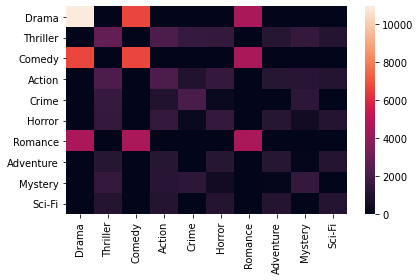

In [0]:
# For the combined model predictions
import seaborn as sns
sns.heatmap(output_combined)
plt.tight_layout()
plt.savefig("combinedCoOccurrence.png",dpi=300)

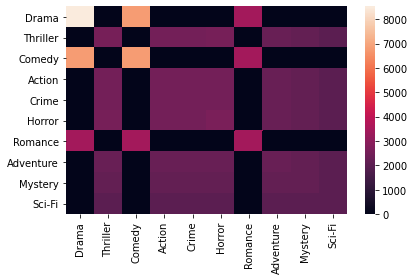

In [0]:
# For BERT
sns.heatmap(output_bert)
plt.tight_layout()
plt.savefig("bertCoOccurrence.png",dpi=300)

In [0]:
output_bert.head(10)

,Drama,Thriller,Comedy,Action,Crime,Horror,Romance,Adventure,Mystery,Sci-Fi
Drama,8531,0,6817,0,0,0,3441,0,0,0
Thriller,0,2582,0,2505,2516,2582,0,2279,2183,2006
Comedy,6817,0,6817,0,0,0,3441,0,0,0
Action,0,2505,0,2505,2504,2505,0,2279,2183,2006
Crime,0,2516,0,2504,2516,2516,0,2279,2183,2006
Horror,0,2582,0,2505,2516,2652,0,2279,2183,2006
Romance,3441,0,3441,0,0,0,3441,0,0,0
Adventure,0,2279,0,2279,2279,2279,0,2279,2183,2006
Mystery,0,2183,0,2183,2183,2183,0,2183,2183,2006
Sci-Fi,0,2006,0,2006,2006,2006,0,2006,2006,2006


In [0]:
label_names = ['Drama','Thriller','Comedy','Action','Crime', 'Horror','Romance','Adventure','Mystery','Sci-Fi']
df_val_trunc.loc[:,'BERTOutputStr'] = df_val_trunc.Bert.astype(str)
df_val_trunc[['BERTOutputStr','movieid']].groupby(by=['BERTOutputStr']).count().reset_index().sort_values(['movieid'], ascending=False)[:]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,BERTOutputStr,movieid
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4177
11,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]",3441
10,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",3376
8,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 1]",2006
9,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1714
5,"[0, 1, 0, 1, 1, 1, 0, 0, 0, 0]",225
7,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 0]",177
6,"[0, 1, 0, 1, 1, 1, 0, 1, 0, 0]",96
1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",70
2,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]",65


## Other Stuff

In [0]:
temp = [np.array(np.abs(rows['Combined'] - np.array(rows['label_list']))).sum() for index, rows in df_val_trunc.iterrows() ]

In [0]:
(np.array(temp) == 0).astype(int).sum()

1474

In [0]:
def plot_year_accuracy(df, label_index = [0]):
    out = []
    out_real = []
    for index, rows in df.iterrows():
        new_list = np.array([])
        new_list_actual = np.array([])
        for cols in label_index:
            new_list = np.append(new_list, (np.array(np.abs(rows['Combined'][cols] - np.array(rows['label_list'][cols]))).sum()))
            new_list_actual = np.append(new_list_actual, np.array(rows['label_list'][cols]))
        out.append(new_list)
        out_real.append(new_list_actual)
    return(np.array(out), np.array(out_real))

In [0]:
out, out_real = plot_year_accuracy(df_val_trunc, label_index = range(0,NUM_LABELS))

In [0]:
print(out[:,9].sum()/out.shape[0])
print(out_real[:,9].sum()/out.shape[0])

0.08138020833333333
0.061848958333333336


In [0]:
((out == 0).sum(axis=0))/out.shape[0]


array([0.61217448, 0.75559896, 0.59407552, 0.79257813, 0.79641927,
       0.85696615, 0.70436198, 0.87115885, 0.85592448, 0.91861979])

In [0]:
my_list_index = [i for i in range(len(temp)) if temp[i] == 0]

In [0]:
df_val_trunc.iloc[my_list_index].head()

,movieid_poster,indexes,movieid,movieplot,labels,year,Combined,Bert,label_list
13,tt1230414.jpg,53640,tt1230414.jpg,"When brought together at a family event, two e...","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]",2009,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
28,tt0072783.jpg,6724,tt0072783.jpg,Raghav brags that he can smell a rat or an imp...,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]",1975,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
29,tt3402232.jpg,17439,tt3402232.jpg,On 8th February 2000 at Feltham Young Offender...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2014,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 1, 1, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
46,tt8471716.jpg,72750,tt8471716.jpg,A mother finds out that her daughter not only ...,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]",2019,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
57,tt0357283.jpg,51093,tt0357283.jpg,Widowed Ayesha Khan lives a poor lifestyle in ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2003,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(2010, 2020]    471
(2000, 2010]    382
(1990, 2000]    181
(1980, 1990]    112
(1970, 1980]     94
Name: year, dtype: int64

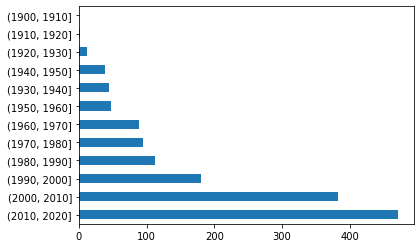

In [0]:
import matplotlib.pyplot as plt
df_val_trunc.year = df_val_trunc.year.astype(int)
bins = [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
#bin1 = pd.cut(df_val_trunc.iloc[my_list_index].year, bins)
s = pd.cut(df_val_trunc.iloc[my_list_index].year, bins=bins).value_counts()
s.plot(kind='barh')
#plt.show()
s.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(2010, 2020]    4540
(2000, 2010]    3560
(1990, 2000]    1881
(1980, 1990]    1374
(1970, 1980]    1097
Name: year, dtype: int64

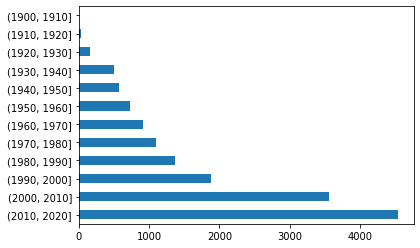

In [0]:
df_val_trunc.year = df_val_trunc.year.astype(int)
bins = [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
#bin1 = pd.cut(df_val_trunc.iloc[my_list_index].year, bins)
s2 = pd.cut(df_val_trunc.year, bins=bins).value_counts()
s2.plot(kind='barh')
#plt.show()
s2.head()

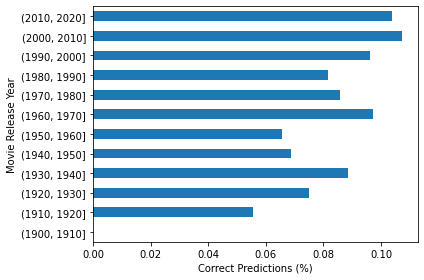

In [0]:
(s/s2).plot(kind='barh')
plt.xlabel('Correct Predictions (%)')
plt.ylabel('Movie Release Year')
plt.tight_layout()
plt.savefig("yearlyPrediction.png",dpi=300)

In [0]:
temp_bert = [np.array(np.abs(rows['Bert'] - np.array(rows['label_list']))).sum(axis=0) for index, rows in df_val_trunc.iterrows() ]
my_list_index_bert = [i for i in range(len(temp_bert)) if temp_bert[i] == 0]
df_val_trunc.iloc[my_list_index_bert].head(20)

,movieid_poster,indexes,movieid,movieplot,labels,Combined,Bert,label_list
32,tt0260760.jpg,9093,tt0260760.jpg,"Five boys and girls, aged 20-25, take on an In...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
67,tt1020889.jpg,37668,tt1020889.jpg,"In the 90s, Lena returns to the home of her gr...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
85,tt0329421.jpg,62325,tt0329421.jpg,The adventures of a small town Croatian family...,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
91,tt0120763.jpg,33526,tt0120763.jpg,Three homeless teenage rejects struggle to sur...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
97,tt0022619.jpg,72855,tt0022619.jpg,Karl is the workaholic adopted son while Steph...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
102,tt5105218.jpg,61186,tt5105218.jpg,Four tragicomic interconnected stories about h...,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
126,tt0056987.jpg,31078,tt0056987.jpg,Raid on Drvar known as 'The Seventh Enemy Offe...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
138,tt0252591.jpg,58680,tt0252591.jpg,"A janitor/doorman and his family who came to ""...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
164,tt0380609.jpg,3631,tt0380609.jpg,"Louise Harrington, a divorced, thirty-somethin...","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
175,tt0419815.jpg,21434,tt0419815.jpg,"Shot on location in Cambodia, including many s...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [0]:
df_val_trunc.movieplot.iloc[81]

'Jimmy Wayne Collins finds himself adrift in Memphis, Tennessee. Forced to return home to the piney woods of Southeast Texas, Jimmy will face his imprisoned brother, his dying father and the demons he left behind.'

In [0]:
print(len(my_list_index))
print(len(my_list_index_bert))

1474
1075


In [0]:
df_val_trunc.loc[:,"length"] = [len(x.split()) for x in df_val_trunc.movieplot]
df_val_trunc.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,movieid_poster,indexes,movieid,movieplot,labels,Combined,Bert,label_list,length
0,tt0039689.jpg,72357,tt0039689.jpg,"In a small town in California, the mysterious ...","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 1, 1, 0, 1, 1, 1]","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0]",188
1,tt7287656.jpg,71319,tt7287656.jpg,Su is a dreamer who believes that the love of ...,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]",59
2,tt2754854.jpg,56809,tt2754854.jpg,"In the rural farm town of Appleton, Wisconsin,...","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",49
3,tt0035034.jpg,32236,tt0035034.jpg,Hank McHenry and Johnny Marshall work on a roa...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",57
4,tt4532826.jpg,28727,tt4532826.jpg,"Robin of Loxley, a lord living in Nottingham, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0]",250


In [0]:
df_val_trunc.loc[:,"CorrectCombined"] = 0
df_val_trunc.CorrectCombined.iloc[my_list_index] = 1
df_val_trunc.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

,movieid_poster,indexes,movieid,movieplot,labels,Combined,Bert,label_list,length,CorrectCombined
0,tt0039689.jpg,72357,tt0039689.jpg,"In a small town in California, the mysterious ...","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 1, 1, 0, 1, 1, 1]","[1, 1, 0, 0, 1, 0, 1, 0, 0, 0]",188,0
1,tt7287656.jpg,71319,tt7287656.jpg,Su is a dreamer who believes that the love of ...,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]",59,0
2,tt2754854.jpg,56809,tt2754854.jpg,"In the rural farm town of Appleton, Wisconsin,...","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",49,0
3,tt0035034.jpg,32236,tt0035034.jpg,Hank McHenry and Johnny Marshall work on a roa...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",57,0
4,tt4532826.jpg,28727,tt4532826.jpg,"Robin of Loxley, a lord living in Nottingham, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0]",250,0


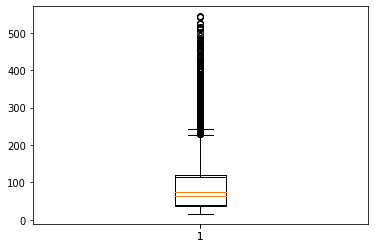

In [0]:
import matplotlib.pyplot as plt
plt.figure()
plt.boxplot(df_val_trunc.loc[df_val_trunc.CorrectCombined==0,:].length)
#holdon
plt.boxplot(df_val_trunc.loc[df_val_trunc.CorrectCombined==1,:].length)
plt.show()

In [0]:
for items in df_val_trunc.Combined.astype(str).unique():
    if items in list(df_val_trunc.labels.astype(str).unique()):
        print(items)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
[0, 1, 0, 1, 1, 0, 0, 0, 1, 0]
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 1, 0, 0, 1, 0]
[0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
[0, 1, 0, 1, 0, 1, 0, 0, 1, 0]
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 1, 0, 1, 1, 1]


In [0]:
for items in df_val_trunc.Bert.astype(str).unique():
    if items in list(df_val_trunc.labels.astype(str).unique()):
        print(items)

[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 1, 0, 0, 0, 0]


In [0]:
df_val_trunc[['labels','movieid']].groupby(by=['labels']).count().reset_index().sort_values(['movieid'], ascending=False)[:20]

,labels,movieid
230,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3018
69,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1659
285,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",973
237,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]",962
76,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]",618
292,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]",529
13,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",416
253,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]",320
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",307
320,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",299


In [0]:
label_names = ['Drama','Thriller','Comedy','Action','Crime',
                   'Horror','Romance','Adventure','Mystery','Sci-Fi']
df_val_trunc.loc[:,"CombinedStr"] = df_val_trunc.Combined.astype(str)
df_val_trunc[['CombinedStr','movieid']].groupby(by=['CombinedStr']).count().reset_index().sort_values(['movieid'], ascending=False)[:]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,CombinedStr,movieid
13,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]",4631
11,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4219
12,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",2069
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1073
6,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]",1022
9,"[0, 1, 0, 1, 1, 0, 0, 0, 1, 0]",711
1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",584
3,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",331
10,"[0, 1, 0, 1, 1, 1, 0, 0, 1, 0]",262
2,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]",242


In [0]:
#Image 

import tensorflow_hub as hub
import tensorflow as tf

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
resnet_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",trainable=False)
feature_vector = resnet_layer(inputs)
model = tf.keras.models.Model(inputs=inputs, outputs=feature_vector)
model.summary()

In [0]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
def parse_function(filename,label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

BATCH_SIZE = 1024 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

In [0]:
df_dev_trunc.loc[df_dev_trunc.movieid=='tt0093779.jpg',:].iloc[0]

movieid_poster                                        tt0093779.jpg
indexes                                                       65629
movieid                                               tt0093779.jpg
movieplot         An elderly man reads the book "The Princess Br...
labels                               [0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
Combined                             [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Bert                                 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: 6775, dtype: object

In [0]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset